# Dog breed detector App

### Import Dog Dataset


In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from IPython.display import display

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [27]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Detect Humans with openCV implementation



Number of faces detected: 1


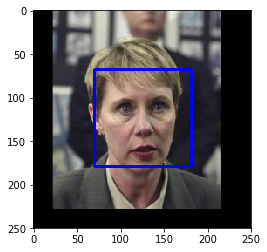

In [28]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[7])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [29]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector



In [30]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
count_humans = 0
count_humans_in_dogs = 0

for i in human_files_short:
    if(face_detector(i)):
        count_humans = count_humans+1

for i in dog_files_short:
    if(face_detector(i)):
        count_humans_in_dogs = count_humans_in_dogs+1

print("Performance of face detector in human_files_short {}%".format((count_humans/len(human_files_short))*100))
print("Performance of face detector in dog_files_short {}%".format((count_humans_in_dogs/len(dog_files_short))*100))

Performance of face detector in human_files_short 99.0%
Performance of face detector in dog_files_short 11.0%


---
<a id='step2'></a>
## Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [31]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [14]:
#!pip install tqdm
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [32]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector using Resnet

In [33]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

 

In [36]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

count_humans_dogs_resnet = 0
count_dogs_resnet = 0

for i in human_files_short:
    if(dog_detector(i)):
        count_humans_dogs_resnet = count_humans_dogs_resnet+1

for i in dog_files_short:
    if(dog_detector(i)):
        count_dogs_resnet = count_dogs_resnet+1

        
print("Performance of dog detector in human_files_short {}%".format((count_humans_dogs_resnet/len(human_files_short))*100))
print("Performance of dog detector in dog_files_short {}%".format((count_dogs_resnet/len(dog_files_short))*100))


Performance of dog detector in human_files_short 1.0%
Performance of dog detector in dog_files_short 100.0%


---
<a id='step3'></a>
## Create a CNN to Classify Dog Breeds

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:12<00:00, 65.07it/s]


In [7]:
print(train_tensors.shape,valid_tensors.shape,test_tensors.shape)

(6680, 224, 224, 3) (835, 224, 224, 3) (836, 224, 224, 3)


### Model Architecture




In [11]:
#TODO make a re-usable class

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
model = Sequential()
### TODO: Define your architecture.
model.add(BatchNormalization(input_shape = (224,224,3)))
model.add(Conv2D(filters=16,kernel_size=2,input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2))     

model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
#model.add(Flatten())

model.add(Dense(1024,activation='relu' ))
model.add(Dropout(rate=0.3))

model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(133,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 55, 55, 32)        128       
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 33s 5ms/step - loss: 4.7273 - acc: 0.0301 - val_loss: 4.8064 - val_acc: 0.0251
Epoch 2/20
6680/6680 [==============================] - 31s 5ms/step - loss: 4.3221 - acc: 0.0558 - val_loss: 4.4886 - val_acc: 0.0563
Epoch 3/20
6680/6680 [==============================] - 31s 5ms/step - loss: 4.0172 - acc: 0.0847 - val_loss: 4.0392 - val_acc: 0.0754
Epoch 4/20
6680/6680 [==============================] - 31s 5ms/step - loss: 3.7659 - acc: 0.1150 - val_loss: 4.0136 - val_acc: 0.0862
Epoch 5/20
6680/6680 [==============================] - 32s 5ms/step - loss: 3.5094 - acc: 0.1503 - val_loss: 3.6607 - val_acc: 0.1329
Epoch 6/20
6680/6680 [==============================] - 31s 5ms/step - loss: 3.2980 - acc: 0.1864 - val_loss: 3.8353 - val_acc: 0.1473
Epoch 7/20
6680/6680 [==============================] - 32s 5ms/step - loss: 3.0575 - acc: 0.2308 - val_loss: 3.2923 - val_acc: 0.2000
Epoch 8/

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 24.2823%


## Image Augmentation (with same Architecture as above)
let's try Image Augmentation for the same architecture and compare

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True)

datagen_train.fit(train_tensors)

## Defining the Model Architecture

In [19]:
## TODO - Use class object from the previous naive model

model = Sequential()


model.add(BatchNormalization(input_shape = (224,224,3)))
model.add(Conv2D(filters=16,kernel_size=2,input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2))     

model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
#model.add(Flatten())

model.add(Dense(1024,activation='relu' ))
model.add(Dropout(rate=0.3))

model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(133,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 55, 55, 32)        128       
__________

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
epochs = 20
batch = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights_aug.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(datagen_train.flow(train_tensors, train_targets,batch_size=batch),
                    steps_per_epoch = train_tensors.shape[0]//batch,
                    validation_data=(valid_tensors, valid_targets),
                    epochs=epochs,callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 57s 170ms/step - loss: 4.7674 - acc: 0.0283 - val_loss: 4.7029 - val_acc: 0.0299
Epoch 2/20
334/334 [==============================] - 54s 161ms/step - loss: 4.3517 - acc: 0.0506 - val_loss: 4.2467 - val_acc: 0.0563
Epoch 3/20
334/334 [==============================] - 53s 160ms/step - loss: 4.0576 - acc: 0.0796 - val_loss: 4.2974 - val_acc: 0.0731
Epoch 4/20
334/334 [==============================] - 54s 161ms/step - loss: 3.8271 - acc: 0.1106 - val_loss: 3.9038 - val_acc: 0.0910
Epoch 5/20
334/334 [==============================] - 54s 162ms/step - loss: 3.6027 - acc: 0.1436 - val_loss: 3.5635 - val_acc: 0.1281
Epoch 6/20
334/334 [==============================] - 54s 162ms/step - loss: 3.4346 - acc: 0.1705 - val_loss: 3.5686 - val_acc: 0.1521
Epoch 7/20
334/334 [==============================] - 54s 162ms/step - loss: 3.2664 - acc: 0.1969 - val_loss: 3.7510 - val_acc: 0.1820
Epoch 8/20
334/334 [==============================] - 5

In [23]:
model.load_weights('saved_models/weights_aug.best.from_scratch.hdf5')

In [24]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 30.7416%


**With the above architecture and using image augmentation, surprisingly there is a 6% improvement from 24% to 30% which is considreably good. **

## Training Continued..

In [26]:
batch = 20
epochs = 5

model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - 55s 166ms/step - loss: 2.3268 - acc: 0.3838 - val_loss: 3.2286 - val_acc: 0.3018
Epoch 2/5
334/334 [==============================] - 54s 161ms/step - loss: 2.2848 - acc: 0.3877 - val_loss: 2.9266 - val_acc: 0.3257
Epoch 3/5
334/334 [==============================] - 54s 162ms/step - loss: 2.2240 - acc: 0.4153 - val_loss: 2.7466 - val_acc: 0.3126
Epoch 4/5
334/334 [==============================] - 54s 163ms/step - loss: 2.2152 - acc: 0.4124 - val_loss: 2.8558 - val_acc: 0.3401
Epoch 5/5
334/334 [==============================] - 54s 162ms/step - loss: 2.1137 - acc: 0.4361 - val_loss: 2.9505 - val_acc: 0.3126


I tried resuming the training process and couldn't see any improvement in the validation accuracy.

---
<a id='step4'></a>
## Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [9]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [13]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [14]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [16]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 614us/step - loss: 12.6213 - acc: 0.1060 - val_loss: 11.1477 - val_acc: 0.1772
Epoch 2/20
6680/6680 [==============================] - 3s 492us/step - loss: 10.6283 - acc: 0.2507 - val_loss: 10.4115 - val_acc: 0.2707
Epoch 3/20
6680/6680 [==============================] - 3s 517us/step - loss: 10.1292 - acc: 0.3117 - val_loss: 10.2934 - val_acc: 0.2826
Epoch 4/20
6680/6680 [==============================] - 3s 483us/step - loss: 9.7751 - acc: 0.3448 - val_loss: 10.0340 - val_acc: 0.2886
Epoch 5/20
6680/6680 [==============================] - 3s 461us/step - loss: 9.5320 - acc: 0.3731 - val_loss: 9.8507 - val_acc: 0.3174
Epoch 6/20
6680/6680 [==============================] - 3s 496us/step - loss: 9.2323 - acc: 0.3933 - val_loss: 9.6920 - val_acc: 0.3198
Epoch 7/20


6680/6680 [==============================] - 3s 385us/step - loss: 8.9018 - acc: 0.4145 - val_loss: 9.1544 - val_acc: 0.3485
Epoch 8/20
6680/6680 [==============================] - 2s 352us/step - loss: 8.5733 - acc: 0.4370 - val_loss: 9.0736 - val_acc: 0.3617
Epoch 9/20
6680/6680 [==============================] - 2s 348us/step - loss: 8.4877 - acc: 0.4534 - val_loss: 9.0891 - val_acc: 0.3689
Epoch 10/20
6680/6680 [==============================] - 3s 440us/step - loss: 8.4396 - acc: 0.4609 - val_loss: 9.0070 - val_acc: 0.3725
Epoch 11/20
6680/6680 [==============================] - 3s 448us/step - loss: 8.4157 - acc: 0.4672 - val_loss: 8.9833 - val_acc: 0.3880
Epoch 12/20
6680/6680 [==============================] - 3s 473us/step - loss: 8.3562 - acc: 0.4711 - val_loss: 8.8445 - val_acc: 0.3868
Epoch 13/20
6680/6680 [==============================] - 4s 613us/step - loss: 8.2099 - acc: 0.4790 - val_loss: 8.7818 - val_acc: 0.3928
Epoch 14/20


6680/6680 [==============================] - 3s 491us/step - loss: 8.1054 - acc: 0.4868 - val_loss: 8.6170 - val_acc: 0.4024
Epoch 15/20
6680/6680 [==============================] - 3s 473us/step - loss: 7.9898 - acc: 0.4963 - val_loss: 8.6656 - val_acc: 0.3976
Epoch 16/20
6680/6680 [==============================] - 4s 583us/step - loss: 7.9342 - acc: 0.5009 - val_loss: 8.6003 - val_acc: 0.4060
Epoch 17/20
6680/6680 [==============================] - 3s 516us/step - loss: 7.8853 - acc: 0.5034 - val_loss: 8.6034 - val_acc: 0.4108
Epoch 18/20
6680/6680 [==============================] - 4s 544us/step - loss: 7.7912 - acc: 0.5091 - val_loss: 8.5395 - val_acc: 0.4108
Epoch 19/20


6680/6680 [==============================] - 5s 687us/step - loss: 7.7477 - acc: 0.5142 - val_loss: 8.5083 - val_acc: 0.4144
Epoch 20/20
6680/6680 [==============================] - 4s 561us/step - loss: 7.7298 - acc: 0.5159 - val_loss: 8.4568 - val_acc: 0.4072


### Load the Model with the Best Validation Loss

In [17]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [18]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.5933%


### Predict Dog Breed with the Model

In [19]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Create a CNN to Classify Dog Breeds (using Transfer Learning)- Resnet Model


In [3]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet = bottleneck_features['train']
valid_resnet = bottleneck_features['valid']
test_resnet = bottleneck_features['test']

###  Model Architecture - Transfer Learning


In [4]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import regularizers

resnet_model = Sequential()

resnet_model.add(GlobalAveragePooling2D(input_shape=train_resnet.shape[1:]))
resnet_model.add(Dense(512,activation='relu',kernel_regularizer= regularizers.l2(0.001)))
resnet_model.add(Dense(133,activation='softmax'))

resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [5]:
### TODO: Compile the model.

resnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model


## Image Augmentation

In [8]:
## Am not Sure of this implementation

datagen_train_resnet = ImageDataGenerator(width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True)

datagen_train_resnet.fit(train_resnet)

C:\Users\nadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py:683: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 1, 1, 2048) (2048 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [9]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet.hdf5', 
                               verbose=1, save_best_only=True)

resnet_model.fit(train_resnet, train_targets, 
          validation_data=(valid_resnet, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00001: val_loss improved from inf to 1.44823, saving model to saved_models/weights.best.ResNet.hdf5
 - 14s - loss: 2.3326 - acc: 0.5542 - val_loss: 1.4482 - val_acc: 0.7078
Epoch 2/20
Epoch 00002: val_loss did not improve
 - 13s - loss: 1.1068 - acc: 0.7916 - val_loss: 1.5339 - val_acc: 0.6982
Epoch 3/20
Epoch 00003: val_loss did not improve
 - 14s - loss: 0.8754 - acc: 0.8457 - val_loss: 1.6393 - val_acc: 0.6874
Epoch 4/20
Epoch 00004: val_loss improved from 1.44823 to 1.20616, saving model to saved_models/weights.best.ResNet.hdf5
 - 13s - loss: 0.7805 - acc: 0.8702 - val_loss: 1.2062 - val_acc: 0.7701
Epoch 5/20
Epoch 00005: val_loss did not improve
 - 13s - loss: 0.6861 - acc: 0.8880 - val_loss: 1.2559 - val_acc: 0.7713
Epoch 6/20
Epoch 00006: val_loss did not improve
 - 13s - loss: 0.6196 - acc: 0.8984 - val_loss: 1.2851 - val_acc: 0.7629
Epoch 7/20
Epoch 00007: val_loss did not improve
 - 13s - loss: 0.5983 - acc: 0.9

### Load the Model with the Best Validation Loss

In [10]:
### TODO: Load the model weights with the best validation loss.
resnet_model.load_weights('saved_models/weights.best.ResNet.hdf5')

###  Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [11]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
resnet_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1))/len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.3062%


### Predict Dog Breed with the Model


In [12]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def ResNet_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = resnet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

Checking...

In [15]:
ResNet_predict_breed('dogImages/test/004.Akita/Akita_00258.jpg')

'Akita'

---
<a id='step6'></a>


# Algorithm for Dog App

This Algorithm predicts the dog breed from the image of the dog. If the image is given of a human or any other species, it gives the similar dog breed for the image. 

In [46]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

class DogApp:
    
    def __init__(self,imgPath):
        self.isDog = False
        self.isHuman = False
        self.neither = False
        self.imgPath = imgPath
        self.dogImgpath = "dogImages/train"
        
    def checkDogorHuman(self):
        imgPath = self.imgPath
        if (dog_detector(imgPath)):
            self.isDog = True
        elif (face_detector(imgPath)):
            self.isHuman = True
        else:
            self.neither = True
        
    def displayImage(self,imgPath,breed):
        plt.figure(1)
        plt.subplot(221)
        plt.title("Actual Image...")
        img = cv2.imread(imgPath)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)
        plt.subplot(222)
        plt.title("Predicted dog Breed.. \n {}".format(breed))
        dogImgPath = self.getFilePath(breed)
        digImg = cv2.imread(dogImgPath)
        cv_rgb = cv2.cvtColor(digImg, cv2.COLOR_BGR2RGB)
        dogImgPlot = plt.imshow(cv_rgb)
        plt.show()
        
    def getFilePath(self,breed):
        import os
        dirArray = os.listdir(self.dogImgpath)
        for name in dirArray:
            if(breed == name.split('.')[1]):
                imgDir = self.dogImgpath+"/"+name
                imgPath = imgDir+"/"+os.listdir(imgDir)[0] # get's the first file from the directory
                return imgPath
        
    def runApp(self):
        imgPath = self.imgPath
        if(self.isDog):
            breed = ResNet_predict_breed(imgPath)
            print("Predicted a Dog of Breed {}".format(breed))
            self.displayImage(imgPath,breed)
        if(self.isHuman):
            breed = ResNet_predict_breed(imgPath)
            print("Predicted a Human Face, Relative dog breed is {}".format(breed))
            self.displayImage(imgPath,breed)
        if(self.neither):
            breed = ResNet_predict_breed(imgPath)
            print("Neither Dog nor Human")
            self.displayImage(imgPath,breed) 
    



---
<a id='step7'></a>
## Testing the Algorithm


Predicted a Dog of Breed Akita


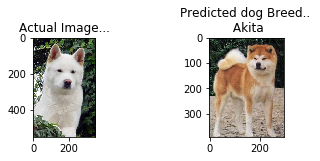

In [38]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

app1 = DogApp('dogImages/test/004.Akita/Akita_00258.jpg')
app1.checkDogorHuman()
app1.runApp()

Predicted a Dog of Breed Basset_hound


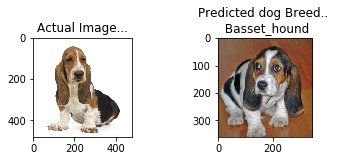

In [39]:
app1 = DogApp('dogImages/test/015.Basset_hound/Basset_hound_01071.jpg')
app1.checkDogorHuman()
app1.runApp()

Predicted a Dog of Breed Chihuahua


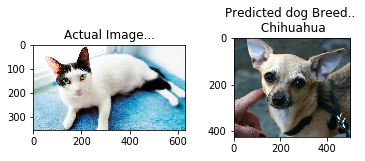



Neither Dog nor Human


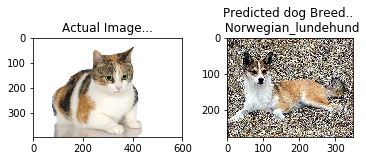



Predicted a Human Face, Relative dog breed is Akita


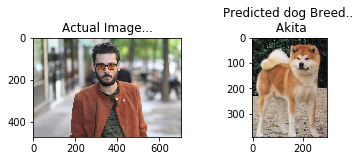



Predicted a Human Face, Relative dog breed is Afghan_hound


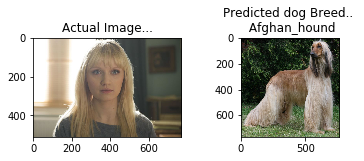

In [47]:
for test_img in glob("test_images/*"):
    app = DogApp(test_img)
    app.checkDogorHuman()
    app.runApp()
    print("\n")